In [1]:
import os
import pandas as pd
import glob

In [2]:
path_input=os.path.join(os.getcwd(), '../data/input/dresden/2019/')
path_output_weather = os.path.join(os.getcwd(), '../data/output/weather/')
path_output=os.path.join(os.getcwd(), '../data/output/')

## Read Data

In [3]:
directors = glob.glob(path_input+"*")

all_files = []
for director in directors:
    all_files=all_files+glob.glob(director+"/*.csv")
    
li = []

for filename in all_files:
    df_read = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_read)

df = pd.concat(li, axis=0, ignore_index=True)

## Drop Columns

In [4]:
#Columns including single value
#The following columns only included one value (or NaN values)
#city : ['dresden']
#p_rack_locks : [False]
#b_state : ['ok']
#b_active : [ True]
#b_battery_pack : [nan '{"percentage": 0}']
#p_special_racks : [nan 0.]
#p_free_special_racks : [nan 0.]

#Columns which highly correlate

#The following columns highly correlate - meaning they are complementary booleans or if one is high, the other is too

#p_bike [corr(p_spot)=-0.999501, complementary boolean to p_spot]

df_cleaned = df.drop(["city", 
                      "p_bike", 
                      "p_rack_locks", 
                      "b_active", 
                      "b_state", 
                      "b_battery_pack", 
                      "p_rack_locks", 
                      "p_special_racks", 
                      "p_free_special_racks"], axis=1)
df_cleaned.head()

,p_bike_racks,p_spot,p_booked_bikes,p_place_type,datetime,b_number,trip,p_uid,p_bikes,p_lat,...,p_free_racks,p_address,b_lock_types,p_number,b_pedelec_battery,p_lng,b_boardcomputer,p_maintenance,p_terminal_type,p_bike_types
0,0,True,0,0,2019-01-20 00:00:00,93716,first,264546,3,51.033548,...,0,NaN,analog_code_lock,4346.0,0.0,13.748800,0,False,NaN,"{""undefined"": 2, ""15"": 1}"
1,0,True,0,0,2019-01-20 09:40:00,93716,start,264546,3,51.033548,...,0,NaN,analog_code_lock,4346.0,0.0,13.748800,0,False,NaN,"{""undefined"": 2, ""15"": 1}"
2,0,True,0,0,2019-01-20 09:58:00,93716,end,264595,2,51.058771,...,0,NaN,analog_code_lock,4389.0,0.0,13.769281,0,False,NaN,"{""15"": 2}"
3,0,True,0,0,2019-01-20 17:36:00,93716,start,264595,3,51.058771,...,0,NaN,analog_code_lock,4389.0,0.0,13.769281,0,False,NaN,"{""15"": 3}"
4,0,True,0,0,2019-01-20 19:39:00,93716,end,100894,1,51.067153,...,0,NaN,analog_code_lock,4361.0,0.0,13.776480,0,False,NaN,"{""15"": 1}"


## Create Trips

In [5]:
# No Duplicates
len(df_cleaned)-len(df_cleaned.drop_duplicates(subset=df_cleaned.columns.difference(["p_lat", "p_lng"])))

0

In [6]:
print("Starts:", len(df_cleaned[df_cleaned["trip"]=="start"]))
print("Ends:", len(df_cleaned[df_cleaned["trip"]=="end"]))
print("Difference:", len(df_cleaned[df_cleaned["trip"]=="start"])-len(df_cleaned[df_cleaned["trip"]=="end"]))

Starts: 565996
Ends: 550350
Difference: 15646


In [7]:
# df_2: start and end of trips
df_2 = df_cleaned[(df_cleaned["trip"]=="start") | (df_cleaned["trip"]=="end")]
print("Dropped", len(df_cleaned)-len(df_2), "first and last Values")

Dropped 290120 first and last Values


In [8]:
# df_3: start and end of trips sorted by b_number and datetime
df_3=df_2.sort_values(["b_number", "datetime"])
df_3[["b_number", "datetime", "trip"]].iloc[500010:500030] # two examples for multiple starts

,b_number,datetime,trip
669292,93554,2019-07-05 13:37:00,start
669293,93554,2019-07-05 13:46:00,end
669294,93554,2019-07-05 14:20:00,start
669295,93554,2019-07-05 14:35:00,end
669296,93554,2019-07-05 16:44:00,start
669297,93554,2019-07-05 16:51:00,start
669298,93554,2019-07-05 17:29:00,end
669299,93554,2019-07-05 18:48:00,start
669300,93554,2019-07-05 19:18:00,end
669301,93554,2019-07-05 20:20:00,start


In [9]:
# sr_1: True if after start entry comes end entry else False
sr_1 = (df_3['trip'] != df_3['trip'].shift())
df_3["valid_start"]=sr_1

# sr_2: 
#sr_2 = (df_3['trip'] != df_3['trip'].shift(-1))
#df_3['valid_end'] = sr_2


In [10]:
# df_4: start and end of trips sorted by b_number and datetime only valid starts
df_4=df_3[df_3["valid_start"]==True]
print("Deleted entries", len(df_3)-len(df_4))
print("Correct entries", len(df_4))

Deleted entries 15646
Correct entries 1100700


In [11]:
# Tests if there are values with two ends after each other
test = df_4["trip"] != df_4["trip"].shift(-1)
print("Entries where Bike X ends with an end and bike Y starts with an end")
pd.DataFrame(test)[pd.DataFrame(test)["trip"]==False]

Entries where Bike X ends with an end and bike Y starts with an end


,trip


In [12]:
df_starts = df_4[df_4["trip"]=="start"].reset_index(drop=True)
df_ends = df_4[df_4["trip"]=="end"].reset_index(drop=True)



In [13]:
print(df_starts.head()[["b_number", "datetime", "trip"]], "\n")
print(df_ends.head()[["b_number", "datetime", "trip"]])

   b_number             datetime   trip
0     11225  2019-04-29 06:31:00  start
1     11225  2019-04-29 11:27:00  start
2     11225  2019-04-29 11:58:00  start
3     11225  2019-04-29 12:22:00  start
4     11225  2019-04-29 13:00:00  start 

   b_number             datetime trip
0     11225  2019-04-29 06:35:00  end
1     11225  2019-04-29 11:33:00  end
2     11225  2019-04-29 12:03:00  end
3     11225  2019-04-29 12:39:00  end
4     11225  2019-04-29 13:14:00  end


In [14]:
df_merged = df_starts.merge(df_ends, left_on=df_starts.index, right_on=df_ends.index, suffixes=("_start", "_end"))
df_merged.drop(["key_0", 
                "valid_start_start", 
                "valid_start_end", 
                "trip_start", 
                "trip_end", 
                "b_number_end", 
                "b_boardcomputer_end", 
                "b_pedelec_battery_end", 
                "b_lock_types_end", 
                "b_bike_type_end", 
                "b_electric_lock_end"], axis=1, inplace=True)
df_merged.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_address_end,p_number_end,p_lng_end,p_maintenance_end,p_terminal_type_end,p_bike_types_end
0,0,True,0,0,2019-04-29 06:31:00,11225,264595,1,51.058771,True,...,1,51.058771,Gutenbergstraße,0,NaN,4389.0,13.769281,False,NaN,"{""15"": 1}"
1,0,False,0,12,2019-04-29 11:27:00,11225,15109859,1,50.806704,True,...,1,50.813655,BIKE 11225,0,NaN,0.0,8.770495,False,NaN,"{""15"": 1}"
2,0,False,0,12,2019-04-29 11:58:00,11225,15117356,1,50.813655,True,...,1,50.808976,BIKE 11225,0,NaN,0.0,8.772863,False,NaN,"{""15"": 1}"
3,0,False,0,12,2019-04-29 12:22:00,11225,15118389,1,50.808976,True,...,1,50.822621,BIKE 11225,0,NaN,0.0,8.774550,False,NaN,"{""15"": 1}"
4,0,False,0,12,2019-04-29 13:00:00,11225,15119670,1,50.822621,True,...,1,50.813241,BIKE 11225,0,NaN,0.0,8.763238,False,NaN,"{""15"": 1}"


## Merge Trips with Weather data

In [15]:
df_dwd=pd.read_csv(os.path.join(path_output_weather, "DWD.csv"))
df_dwd['MESS_DATUM'] = pd.to_datetime(df_dwd['MESS_DATUM'].astype(str), format="%Y-%m-%d %H:%M:%S", errors='coerce')

df_merged["datetime_start"] = pd.to_datetime(df_merged["datetime_start"].astype(str), format="%Y-%m-%d %H:%M:%S", errors="coerce")

In [16]:
df_full = pd.merge_asof(df_merged.sort_values('datetime_start'), 
                        df_dwd, left_on='datetime_start', 
                        right_on='MESS_DATUM', 
                        tolerance=pd.Timedelta('30 min'),
                        allow_exact_matches=True, direction='nearest')

In [17]:
df_full.head(5)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,p_terminal_type_end,p_bike_types_end,Unnamed: 0,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,NaN,"{""15"": 1}",1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,NaN,"{""15"": 1}",1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,free,"{""undefined"": 1, ""15"": 2}",1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
3,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,NaN,"{""undefined"": 3, ""15"": 2}",1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
4,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,NaN,"{""undefined"": 1}",1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3


In [18]:
df_full.drop("Unnamed: 0", inplace=True, axis=1)

In [19]:
# cast start&end times to datetimes
df_full['datetime_start'] = pd.to_datetime(df_full['datetime_start'])
df_full['datetime_end'] = pd.to_datetime(df_full['datetime_end'])
# calculate trip duration
df_full['trip_duration'] = ((df_full['datetime_end'] - df_full['datetime_start']).dt.total_seconds() / 60.0).round(2)

In [20]:
df_full.to_csv(os.path.join(path_output, "Trips.csv"))

In [90]:
# Activate parameter to show ALL columns from dataframe
pd.set_option('display.max_columns', None)
df_full.head(10)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,p_address_start,b_lock_types_start,p_number_start,b_pedelec_battery_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_terminal_type_start,p_bike_types_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_address_end,p_number_end,p_lng_end,p_maintenance_end,p_terminal_type_end,p_bike_types_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration,boolAsInt
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,15,BIKE 93771,0,NaN,analog_code_lock,0.0,0.0,13.750380,22532,False,NaN,"{""15"": 1}",0,False,0,12,2019-01-20 00:28:00,12099518,1,51.046234,BIKE 93771,0,NaN,0.0,13.693052,False,NaN,"{""15"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,0
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,15,Wohnheim Gret-Palucca.Straße / Lenneplatz,0,NaN,analog_code_lock,4486.0,0.0,13.744712,0,False,free,"{""undefined"": 2, ""15"": 3}",0,False,0,12,2019-01-20 00:15:00,12099344,1,51.049069,BIKE 93576,0,NaN,0.0,13.744122,False,NaN,"{""15"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,10.0,1
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,0,Malterstraße (Haltestelle),0,NaN,frame_lock,4483.0,0.0,13.691130,7551004130,False,free,"{""undefined"": 1}",0,True,0,0,2019-01-20 00:33:00,4405670,3,51.028370,Wundtstr. / Zellescher Weg,0,NaN,4458.0,13.747730,False,free,"{""undefined"": 1, ""15"": 2}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,26.0,1
3,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,15,Friedensstraße/Conradstr.,0,NaN,analog_code_lock,4373.0,0.0,13.741257,0,False,NaN,"{""undefined"": 3, ""15"": 2}",0,True,0,0,2019-01-20 00:35:00,264575,5,51.071740,Friedensstraße/Conradstr.,0,NaN,4373.0,13.741257,False,NaN,"{""undefined"": 3, ""15"": 2}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,1
4,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,0,BIKE 93322,0,NaN,analog_code_lock,0.0,0.0,13.689620,1265,False,NaN,"{""undefined"": 1}",0,False,0,12,2019-01-20 00:09:00,12098234,1,51.041798,BIKE 93322,0,NaN,0.0,13.689620,False,NaN,"{""undefined"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0
5,0,True,0,0,2019-01-20 00:21:00,93660,45444,1,51.025741,False,15,Panometer,0,NaN,analog_code_lock,4310.0,0.0,13.789338,0,False,NaN,"{""15"": 1}",0,True,0,0,2019-01-20 00:33:00,264532,1,51.034938,Altenberger Platz,0,NaN,4336.0,13.807733,False,NaN,"{""15"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,12.0,1
6,0,False,0,12,2019-01-20 00:26:00,93478,12098942,1,51.028163,False,0,BIKE 93478,0,NaN,analog_code_lock,0.0,0.0,13.710755,1206,False,NaN,"{""undefined"": 1}",0,True,0,0,2019-01-20 00:28:00,10299678,1,51.023416,Räcknitzhöhe,0,NaN,4491.0,13.742453,False,free,"{""undefined"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0
7,0,True,0,0,2019-01-20 00:29:00,93577,264599,1,51.044740,False,15,Mosenstraße,0,NaN,analog_code_lock,4392.0,0.0,13.777725,0,False,NaN,"{""15"": 1}",0,True,0,0,2019-01-20 00:31:00,264599,1,51.044740,Mosenstraße,0,NaN,4392.0,13.777725,False,NaN,"{""15"": 1}",2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,1
8,0,True,0,0,2019-01-20 00:31:00,93258,38955,2,51.060231,False,0,Palaisplatz,0,NaN,analog_code_lock,4403.0,0.0,13.739294,1322,False,NaN,"{""undefined"": 2}",0,True,0,0,2019-01-20 01:02:00,121771,4,51.071144,Schauburg,0,NaN,4327.0,13.750328,False,NaN,"{""undefined"": 3, ""15"": 1}",2019-01-20 01:00:00,-3.4,75.0,0.0,0.0,0.0,4.4,31.0,1
9,0,True,0,0,2019-01-20 00:33:00,93785,264548,2,51.033767,False,15,Nürnberger Ei,0,NaN,analog_code_lock,4348.0,0.0,13.722911,22556,False,free,"{""undefined"": 1, ""15"": 1}",0,True,0,0,2019-01-20 00:49:00,4405670,5,51.028370,Wundtstr. / Zellescher Weg,0,NaN,4458.0,1

# Data exploration of original dataset (dwd + plotting)

In [43]:
# Show number of various entries for each column
print(df_full.count());

p_bike_racks_start         550350
p_spot_start               550350
p_booked_bikes_start       550350
p_place_type_start         550350
datetime_start             550350
b_number_start             550350
p_uid_start                550350
p_bikes_start              550350
p_lat_start                550350
b_electric_lock_start      550350
b_bike_type_start          550350
p_name_start               550350
p_free_racks_start         550350
p_address_start             13220
b_lock_types_start         550350
p_number_start             550288
b_pedelec_battery_start     67149
p_lng_start                550350
b_boardcomputer_start      550350
p_maintenance_start        550350
p_terminal_type_start      134526
p_bike_types_start         550350
p_bike_racks_end           550350
p_spot_end                 550350
p_booked_bikes_end         550350
p_place_type_end           550350
datetime_end               550350
p_uid_end                  550350
p_bikes_end                550350
p_lat_end     

In [35]:
# Show datatypes for every column
df_full.dtypes

p_bike_racks_start                  int64
p_spot_start                         bool
p_booked_bikes_start                int64
p_place_type_start                  int64
datetime_start             datetime64[ns]
b_number_start                      int64
p_uid_start                         int64
p_bikes_start                       int64
p_lat_start                       float64
b_electric_lock_start                bool
b_bike_type_start                   int64
p_name_start                       object
p_free_racks_start                  int64
p_address_start                    object
b_lock_types_start                 object
p_number_start                    float64
b_pedelec_battery_start           float64
p_lng_start                       float64
b_boardcomputer_start               int64
p_maintenance_start                  bool
p_terminal_type_start              object
p_bike_types_start                 object
p_bike_racks_end                    int64
p_spot_end                        

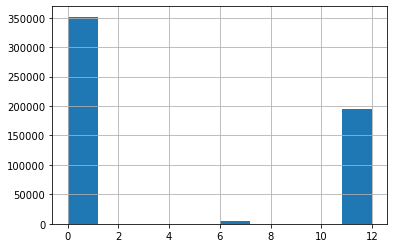

In [28]:
# Show numbers and types of bike racks
df_full["p_bike_racks_start"].hist()

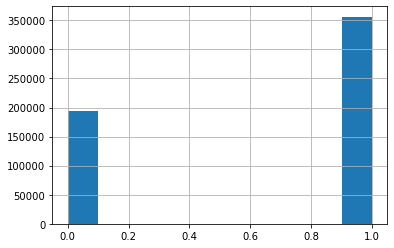

In [94]:
# Show numbers und types of start spots - False and True
df_full["p_spot_start"].astype(int).hist()

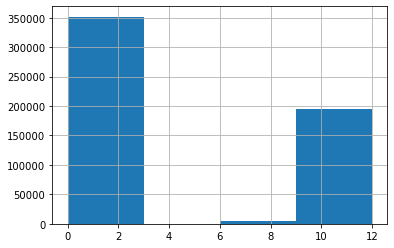

In [99]:
# Show start places for following types - 0, 6, 7 & 12
df_full["p_place_type_start"].hist(bins = 4)

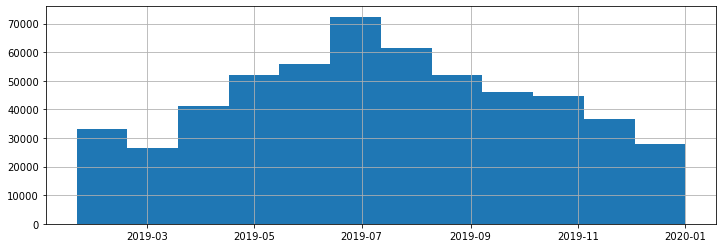

In [70]:
df_full["datetime_start"].hist(figsize=(12, 4), bins=12)

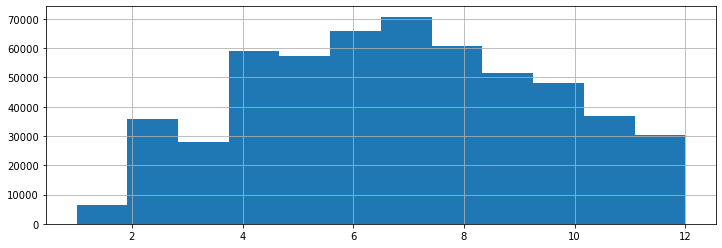

In [69]:
df_full["datetime_start"].dt.month.hist(figsize=(12, 4), bins=12)

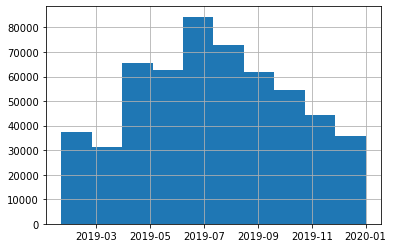

In [71]:
## Show types for bikes starts
df_full["p_bikes_start"].hist()

In [101]:
# Count personal uid for starts
df_full["p_uid_start"].unique().size

160086

In [85]:
# Show 
print(df_full["p_address_start"].unique())

[nan 'recording_64148714' 'August-Bebel-Straße 20' ...
 'prager straße / dr külz ring ' 'Dresden Postplatz, Dresden'
 'recording_91155092']


In [108]:
# Count all NaN values for 'p_address_start'
df_full["p_address_start"].isna().sum()

537130